In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #for balanced


# Load the dataset
file_path = 'rtfDataSet.csv'
original_data = pd.read_csv(file_path)

# Display first few rows of the original dataset
original_data.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,label
0,-0.536,0.292,-0.684,0.123,-0.118,0.346,-0.308,-0.113,0.401,-0.399,...,-0.135,-0.063,-0.410,-0.223,-0.599,-0.136,-0.329,-0.132,-0.266,0
1,-0.496,-0.298,-0.529,0.073,-0.072,0.107,-0.316,-0.066,-0.168,-0.099,...,0.189,0.007,-0.362,-0.151,-0.338,-0.031,-0.159,-0.097,-0.131,0
2,0.008,-0.031,-0.240,0.178,-0.120,0.317,-0.481,0.031,-0.077,0.063,...,-0.035,0.101,-0.098,-0.172,-0.290,0.033,-0.342,-0.321,-0.238,0
3,-0.188,-0.180,-0.062,-0.104,-0.136,-0.061,-0.216,-0.143,0.068,-0.189,...,0.146,-0.145,-0.527,-0.292,-0.663,-0.078,-0.194,-0.151,-0.268,0
4,0.038,0.155,-0.203,-0.088,-0.084,-0.164,-0.145,-0.168,0.008,0.143,...,0.019,-0.084,0.164,-0.165,-0.126,-0.112,0.029,-0.138,0.148,1


In [40]:
# Normalizing the data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(original_data.iloc[:,:-1]), columns=original_data.columns[:-1]) # Normalize all data except for the last column (label)
normalized_data['label'] = original_data['label']
normalized_data.head()

save_csv = 'normalized_dataset.csv'
normalized_data.to_csv(save_csv, index=False)

PermissionError: [Errno 13] Permission denied: 'normalized_dataset.csv'

Selected Features:
Index(['0', '2', '3', '4', '5', '9', '12', '13', '18', '20', '21', '23', '25',
       '27', '28', '30', '31', '33', '34', '36', '38', '41', '43', '44', '46',
       '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '62', '65',
       '68', '69'],
      dtype='object')
Symmetrical Uncertainty Score: 0.0012808068934468905
Importance Per Capita: 3.2841202396074116e-05


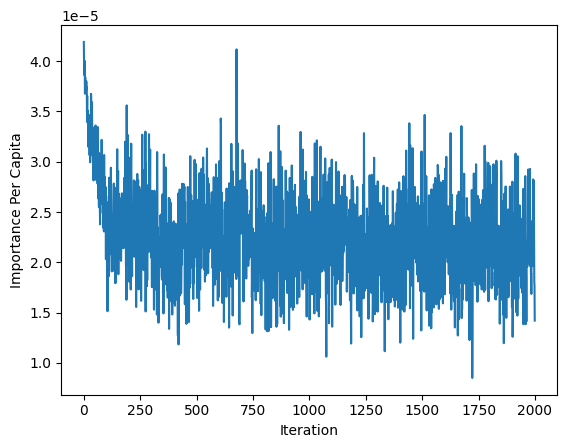

In [45]:


# Load the unnormalized dataset (This can be adjusted to the working dataset in case there is some matching problems)
file_path = 'normalized_dataset.csv'
data = pd.read_csv(file_path)

# Separate the features (X) and labels (y)
X = data.drop(columns=['label'])
y = data['label']

# Apply SMOTE to balance the dataset // Wtf is SMOTE? (—James)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)

# Define the number of iterations for Simulated Annealing
n_iterations = 2000

# Initialize the best solution and its score
best_solution = None
best_score = 0

# Initialize the current solution and its score
current_solution = pd.DataFrame(X_balanced, columns=X.columns)  # Use the balanced dataset
current_score = 0

# Define an initial temperature and cooling rate
T_initial = 4.0  # Initial temperature
alpha = 0.95  # Cooling rate

# Define a small constant to avoid division by zero in the SU function
epsilon = 1e-10

# Symmetrical Uncertainty function
def symmetrical_uncertainty(X, y, epsilon):
    mi = mutual_info_classif(X, y)
    h_x = -np.sum(np.log2((X.sum() + epsilon) / (X.sum().sum() + epsilon)))
    su = 2 * np.sum(mi) / h_x
    return su

# Initialize a list to store the importance scores for each subset
subset_importance_scores = []

# Simulated Annealing loop (this code could be improved)
for iteration in range(n_iterations):
    # Make a small random change to the current solution (feature selection)
    feature_to_change = np.random.choice(current_solution.columns)
    current_solution[feature_to_change] = np.random.choice([0, 1])
    
    # Calculate the Symmetrical Uncertainty score for the current solution
    current_score = symmetrical_uncertainty(current_solution, y_balanced, epsilon=epsilon)
    
    # Calculate the change in score
    delta_score = current_score - best_score
    
    # Accept the new solution with a certain probability based on the temperature
    if delta_score > 0 or np.random.uniform() < np.exp(delta_score / T_initial):
        best_solution = current_solution.copy()
        best_score = current_score
    
    # Update the temperature using the cooling rate
    T_initial *= alpha
    
    # Calculate the importance of the selected features in the current solution
    selected_features = current_solution.columns[current_solution.sum() > 0]
    importance_per_capita = current_score / len(selected_features)
    subset_importance_scores.append(importance_per_capita)

# Print the selected features and their Symmetrical Uncertainty score
selected_features = best_solution.columns[best_solution.sum() > 0]
print("Selected Features:")
print(selected_features)
print("Symmetrical Uncertainty Score:", best_score)

# Calculate the importance per capita for the best solution
best_importance_per_capita = best_score / len(selected_features)
print("Importance Per Capita:", best_importance_per_capita)

# Plot the importance scores over iterations (optional)
import matplotlib.pyplot as plt
plt.plot(range(n_iterations), subset_importance_scores)
plt.xlabel("Iteration")
plt.ylabel("Importance Per Capita")
plt.show()


In [ ]:
# TODO: 3. Top Five Feature Subsets

# Use the feature selection method to identify the top five feature subsets
# Calculate the per capita importance for each subset

In [ ]:

# TODO: 4. AUC Score-based Ranking

# Use a classification model (e.g., logistic regression, SVM, etc.) to evaluate the feature subsets
# Rank the top five feature subsets based on their AUC scores

In [ ]:

# TODO: 5. Interpretation and Conclusion

# Interpret the per capita importance and the AUC scores
# Conclude the study, noting any limitations and suggesting future work